In [1]:
from bounding_box_classification import BoundingBoxClassificationDataset, predict_on_boxes

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_gpu = False

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class JQNet1(nn.Module):
    def __init__(self):
        super(JQNet1, self).__init__()
        if use_gpu:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cuda()
            self.fc2 = nn.Linear(64, 25).cuda()
            self.fc3 = nn.Linear(25,2).cuda()
        else:
            self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cpu()
            self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cpu()
            self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cpu()
            self.conv2_drop = nn.Dropout2d(p = 0.2)
            self.conv3_drop = nn.Dropout2d(p = 0.1)

            #assumes a batch size of 50
            self.fc1 = nn.Linear(31360,64).cpu()
            self.fc2 = nn.Linear(64, 25).cpu()
            self.fc3 = nn.Linear(25,2).cpu()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

        
from torchvision import transforms

net1_data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

1
[True]
()
1
[True]
()
1
[True]
()
1
[True]
()
1
[True]
()
1
[True]
()
1
[True]
()
1
[True]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fee77c4ca10>> ignored


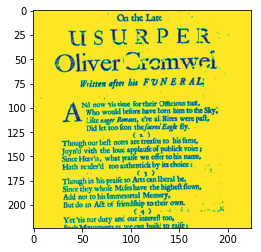

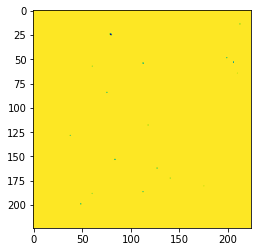

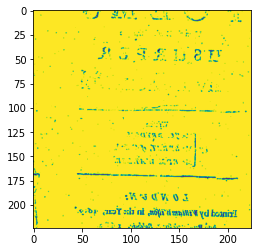

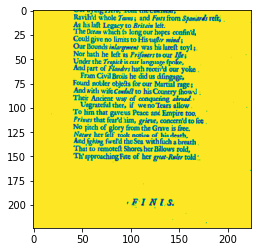

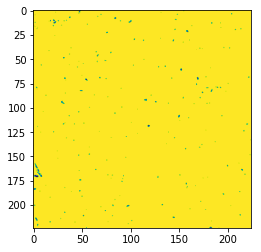

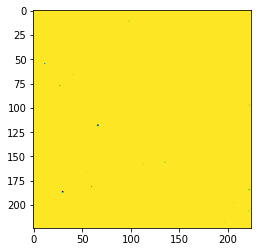

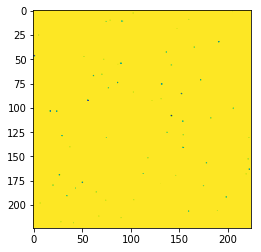

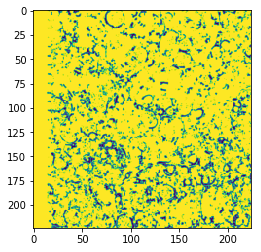

In [3]:
book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'

bbd = BoundingBoxClassificationDataset(book_data_dir + '/Dryden/negative', transform=net1_data_transforms['val'])

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline

dloader = DataLoader(bbd, batch_size=1, shuffle=False, num_workers=4)
jqnet1 = JQNet1()
i = 0
for item in dloader:
    # Note: Each item in DataLoader will be batch_size number of pages
    # Each page can contain numerous images, one for each bounding box
    # predict_on_boxes acts similar to normal prediction, predicting True if any images in the page is predicted positive
    print(len(item))
    for page in item:
        for img in page:
            plt.figure()
            plt.imshow(img[0])
    print(predict_on_boxes(jqnet1, item))
    i += 1
    if i >= 8:
        break
    print()

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_gpu = True

# Set net1.training=False when predicting and net1.training=True when training

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        device = torch.device('cuda' if use_gpu else 'cpu')
        
        self.input_size = (32, 32)
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=4).to(device)
        self.maxpool1 = nn.MaxPool2d(2).to(device)
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=4).to(device)
        self.maxpool2 = nn.MaxPool2d(6).to(device)

        # Todo: check input size of this layer
        self.fc1 = nn.Linear(8000, 100).to(device)
        
        self.batchnorm1 = nn.BatchNorm1d(100).to(device)
        
        self.fc2 = nn.Linear(100, 2).to(device)
        
        # Only use this layer if self.training
        self.conv2_drop = nn.Dropout2d(p = 0.2).to(device)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
            
        # Expand x based on batch size (x.size(0))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = self.batchnorm1(x)
        
        x = self.fc2(x)
        
        if self.training:
            x = self.conv2_drop(x)
        
        return F.log_softmax(x, dim=1)
    
net1transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [5]:

import sys
import os
sys.path.append(os.path.abspath('../../../'))
from detection.lib.model.ImageROI import ImageROI

book_data_dir = '/home/rahul/data/printed_with_ids_harsh_filter/books-preprocessed-images'
img_loc = book_data_dir + '/Dryden/positive/307.png'
# Testing with image of dimensions 1000x1381

from bounding_box_classification import get_pos_rois
net1 = Net1()

# Modify this as necessary
imgrois = [ImageROI(0, 0, 1000, 700), ImageROI(0, 750, 1000, 500)]

pos_rois = get_pos_rois(net1,
                        (img_loc, imgrois),
                        model_transform = net1transform,
                        model_input_size = (256,256),
                        stride=(256, 256))

for rois in pos_rois:
    for roi in rois:
        print(roi.toString())
        
all_rois = [roi for rois in pos_rois for roi in rois]
    
print('number of pos ROIs found', len(all_rois))

from detection.lib.ImgProcessor import ImgProcessor
from detection.lib.utils.Utils import plt_img
# plot the rois and plot only certain information according to the set
imgProcessor = ImgProcessor()
img = imgProcessor.loadImage(inFilename=img_loc)
roi_level_set = set([1])
plt_img(img, rois=[(all_rois, 'r')], roi_level_set=roi_level_set)

RuntimeError: Expected object of type torch.FloatTensor but found type torch.cuda.FloatTensor for argument #2 'weight'